## Esercizio 14.02.25 

A partire dal dataset di auto usate fornito, costruire una pipeline di feature engineering per poi supportare il training di un modello di regressione per il prezzo dell'auto nel mercato dell'usato. Evidenzia in maniera chiara l'effetto che ha la feature engineering nelle metriche di efficacia del modello.

In [6]:
!pip install kagglehub

*1. Caricamento dataset e analisi esplorativa*

In [7]:
import kagglehub
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scarichiamo il dataset
path = kagglehub.dataset_download("taeefnajib/used-car-price-prediction-dataset")

# Estraiamo il file ZIP
zip_files = [f for f in os.listdir(path) if f.endswith(".zip")]
if zip_files:
    zip_path = os.path.join(path, zip_files[0])
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(path)

# Troviamo il file CSV ed esegui il caricamento
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
dataset_path = os.path.join(path, csv_files[0])
df = pd.read_csv(dataset_path)

# Esploriamo i dati
# Controlliamo le prime righe del dataset
print(df.head())

# Verifichiamo la struttura del dataset
print(df.info())

# Controlliamo se ci sono valori mancanti
print(df.isnull().sum())

# Visualizziamo statistiche descrittive per le colonne numeriche
print(df.describe())

# Visualizziamo le features
print(df.columns)

# Conteggio dei valori unici presenti in ogni colonna del DataFrame
print(df.nunique())

      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic        

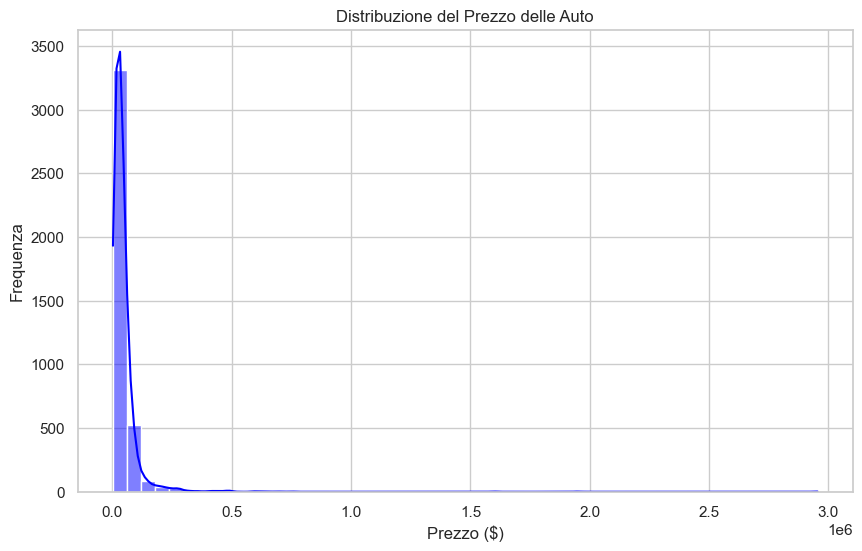

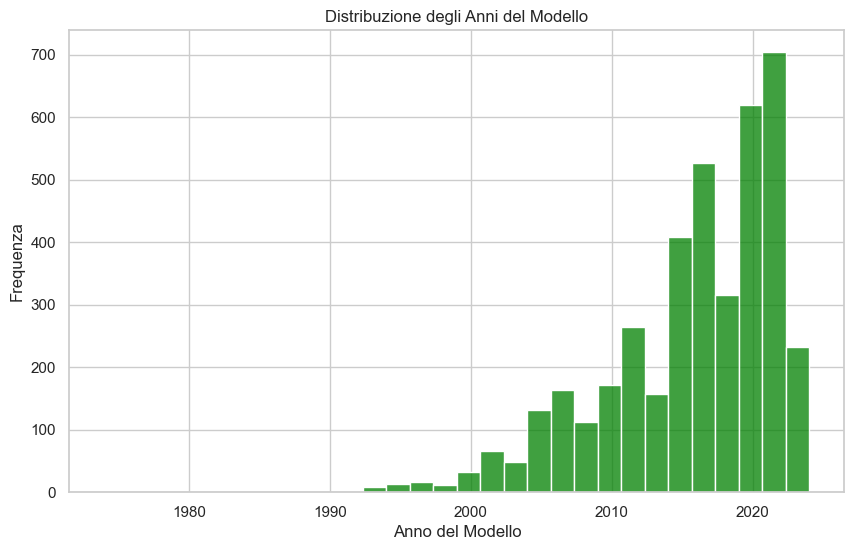

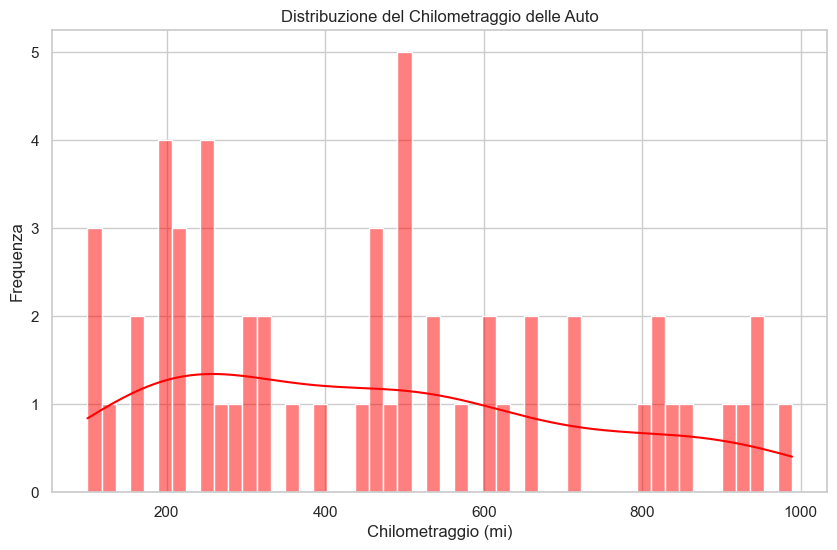

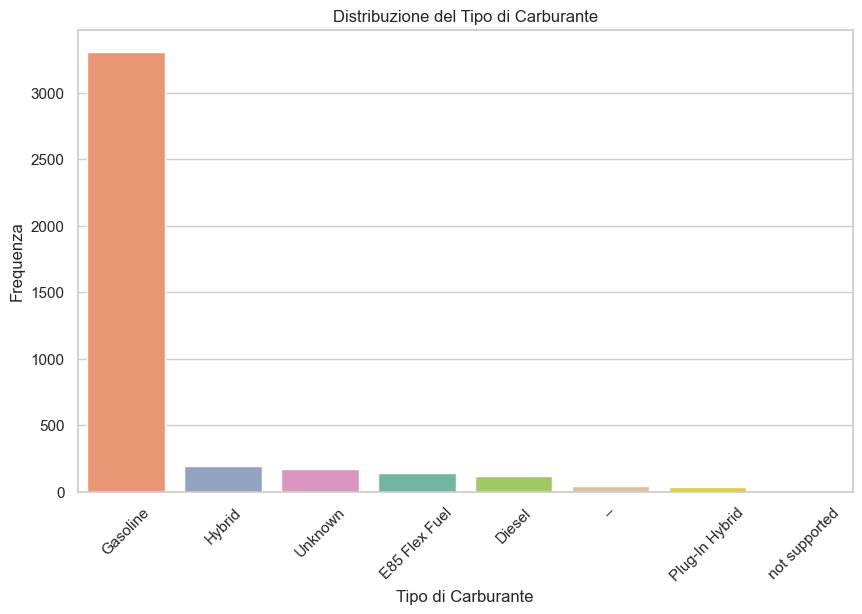

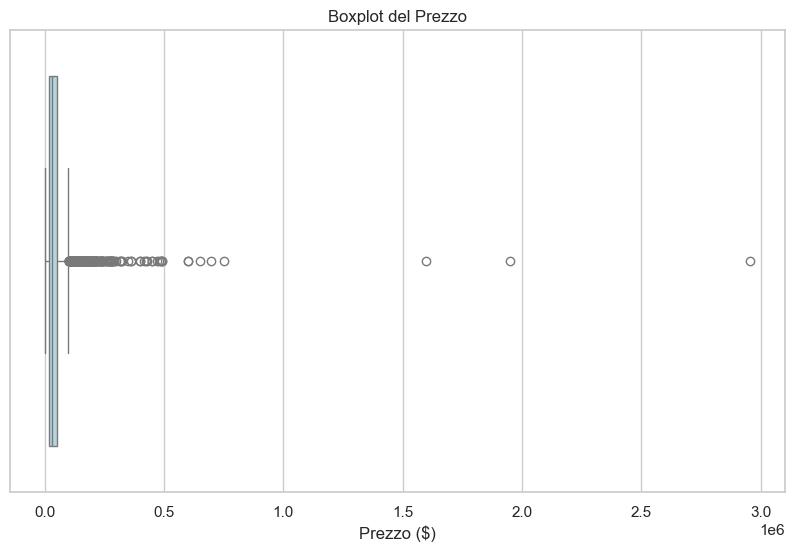

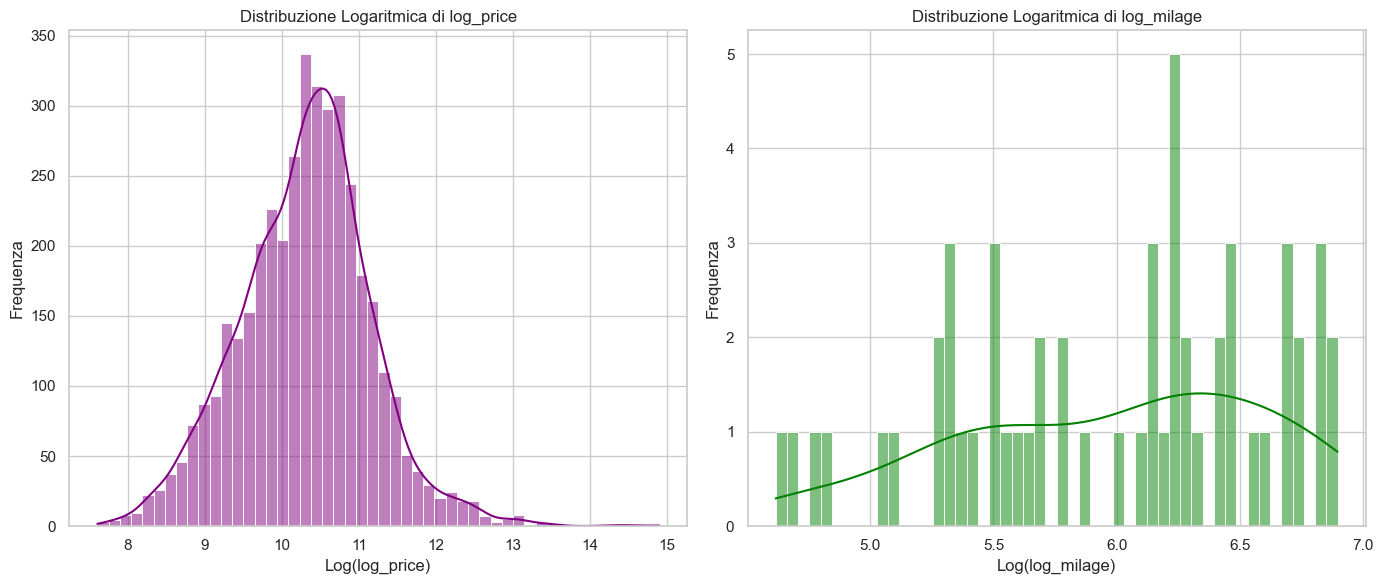

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# Impostiamo il tema per i grafici
sns.set(style="whitegrid")

# Pulizia dei dati

def clean_data(df):
    """
    Funzione per pulire e preparare i dati per l'analisi.
    Rimuove simboli e converte in formato numerico.
    """
    # Rimuove il simbolo del dollaro, la virgola e gli spazi extra nei prezzi
    df['price'] = df['price'].replace({'\\$': '', ',': '', '\\s+': ''}, regex=True)

    # Verifica se ci sono valori non numerici e li converte in NaN
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    # Rimuove "mi." dal chilometraggio e lo converte in numerico
    df['milage'] = df['milage'].replace({' mi.': ''}, regex=True)
    df['milage'] = pd.to_numeric(df['milage'], errors='coerce')

    # Riempiamo i valori nulli con "Unknown" per fuel_type, accident, clean_title
    df['fuel_type'] = df['fuel_type'].fillna('Unknown')
    df['accident'] = df['accident'].fillna('Unknown')
    df['clean_title'] = df['clean_title'].fillna('Unknown')

    return df

df = clean_data(df)

# Funzioni per creare i grafici
def plot_histogram(data, column, color, title, xlabel, ylabel, bins=50, kde=True):
    """
    Funzione per creare istogrammi con KDE.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=kde, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_boxplot(data, column, color, title, xlabel):
    """
    Funzione per creare boxplot.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column], color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

def plot_countplot(data, column, title, xlabel, ylabel):
    """
    Funzione per creare un countplot per variabili categoriche.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, hue=column, palette='Set2', order=data[column].value_counts().index, legend=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

# Grafico 1: Distribuzione dei Prezzi
plot_histogram(df, 'price', 'blue', 'Distribuzione del Prezzo delle Auto', 'Prezzo ($)', 'Frequenza')

# Grafico 2: Distribuzione degli Anni del Modello
plt.figure(figsize=(10, 6))
sns.histplot(df['model_year'], bins=30, kde=False, color='green')
plt.title('Distribuzione degli Anni del Modello')
plt.xlabel('Anno del Modello')
plt.ylabel('Frequenza')
plt.show()

# Grafico 3: Distribuzione del Chilometraggio
plot_histogram(df, 'milage', 'red', 'Distribuzione del Chilometraggio delle Auto', 'Chilometraggio (mi)', 'Frequenza')

# Distribuzione del Tipo di Carburante
plot_countplot(df, 'fuel_type', 'Distribuzione del Tipo di Carburante', 'Tipo di Carburante', 'Frequenza')

# Boxplot del Prezzo
plot_boxplot(df, 'price', 'lightblue', 'Boxplot del Prezzo', 'Prezzo ($)')

# Trasformazione Logaritmica
df['log_price'] = np.log1p(df['price'])  # log(1 + prezzo)
df['log_milage'] = np.log1p(df['milage'])  # log(1 + chilometraggio)

# Grafico Logaritmico
def plot_log_distribution(data, col_name, color, ax):
    """
    Funzione per creare la distribuzione logaritmica (istogramma con KDE).
    """
    sns.histplot(data[col_name], bins=50, kde=True, color=color, ax=ax)
    ax.set_title(f'Distribuzione Logaritmica di {col_name}')
    ax.set_xlabel(f'Log({col_name})')
    ax.set_ylabel('Frequenza')

# Grafico dopo la trasformazione
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Istogramma del prezzo logaritmico
plot_log_distribution(df, 'log_price', 'purple', axes[0])

# Istogramma del chilometraggio logaritmico
plot_log_distribution(df, 'log_milage', 'green', axes[1])

plt.tight_layout()
plt.show()

*2. Pipeline di preprocessing, feature engineering e confronto delle prestazioni*

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Rimuove simboli di dollaro e virgole dalla colonna 'price', quindi converte il valore in formato numerico (float)
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Rimuove la stringa ' mi.' dalla colonna 'milage' e converte i valori in formato numerico (float)
df['milage'] = df['milage'].replace({' mi.': ''}, regex=True).astype(float)

# Feature Engineering
current_year = datetime.now().year
df['car_age'] = current_year - df['model_year']
df['mileage_per_year'] = df['milage'] / (df['car_age'] + 1)  # Evita divisioni per zero
df['price_per_mile'] = df['price'] / df['milage'].replace(0, np.nan)  # Evita divisione per zero

# Gestione NaN
df.fillna(0, inplace=True)

# Identificazione feature
X = df.drop(columns=['price'])
y = df['price']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipeline di pre-processing
numeric_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modello Random Forest con GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Modello XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Modello di base: Regressione Lineare
base_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

# Metriche di valutazione
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}')
    return mae, rmse, r2

print("Risultati:")
mae_rf, rmse_rf, r2_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
mae_xgb, rmse_xgb, r2_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)
mae_base, rmse_base, r2_base = evaluate_model("Modello di Base", y_test, y_pred_base)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Risultati:
Random Forest: MAE=5814.82, RMSE=97761.04, R²=0.5324
XGBoost: MAE=6847.69, RMSE=102634.68, R²=0.4846
Modello di Base: MAE=22756.77, RMSE=121552.92, R²=0.2771


Random Forest è il modello che ha tratto il massimo vantaggio dalle feature ingegnerizzate, con il MAE più basso, un RMSE contenuto e un R² che indica una buona capacità di spiegare la varianza.

XGBoost mostra un miglioramento rispetto al modello di base, ma non è altrettanto performante come Random Forest.

Il modello di base è significativamente meno efficace, con un MAE e RMSE molto più alti e un R² che dimostra una scarsa spiegazione della varianza.

In generale, la feature engineering ha portato ad una riduzione significativa degli errori e ad un aumento della capacità predittiva dei modelli, migliorando quindi le performance rispetto al modello di base.